# Background

In this notebook, I'm using the Eye Movement EOG Dataset from the University of Malta. Here is a link to the dataset: https://www.um.edu.mt/cbc/ourprojects/eyecon/eogdataset/. This dataset is in the form of matlab files with EOG data mapped to one of three classes/eye movements (forward saccade, backward saccade, and blink). The Dataset zip file also has a pdf with more details. I started by visualizing and preprocessing the data minimally. I then trained a preliminary CNN model, which didn't perform too well. Afterwards, I used optuna, an automatic hyperparameter optimization framework, to design a fine tuned CNN for this eye tracking task that performed significantly better, getting >98% test accuracy.

**Reference**  
N. Barbara, T. A. Camilleri, and K. P. Camilleri, “A comparison of EOG baseline drift mitigation techniques,” Biomedical Signal Processing and Control, vol. 57, Mar. 2020. doi: https://doi.org/10.1016/j.bspc.2019.101738

#Imports and Configurations

In [ ]:
import scipy
import matplotlib.pyplot as plt
import os
import pickle
import torch
from torch.utils.data import TensorDataset as TData, DataLoader as DL
import numpy as np
from tqdm.auto import tqdm
from sklearn.metrics import classification_report

In [ ]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.9/400.9 kB 12.2 MB/s eta 0:00:00


In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Loading Data

In [ ]:
!unzip DATASET.zip

Archive:  DATASET.zip
   creating: DATASET/S1/
  inflating: DATASET/S1/ControlSignal.mat  
  inflating: DATASET/S1/EOG.mat      
  inflating: DATASET/S1/TargetGA.mat  
   creating: DATASET/S2/
  inflating: DATASET/S2/ControlSignal.mat  
  inflating: DATASET/S2/EOG.mat      
  inflating: DATASET/S2/TargetGA.mat  
   creating: DATASET/S3/
  inflating: DATASET/S3/ControlSignal.mat  
  inflating: DATASET/S3/EOG.mat      
  inflating: DATASET/S3/TargetGA.mat  
   creating: DATASET/S4/
  inflating: DATASET/S4/ControlSignal.mat  
  inflating: DATASET/S4/EOG.mat      
  inflating: DATASET/S4/TargetGA.mat  
   creating: DATASET/S5/
  inflating: DATASET/S5/ControlSignal.mat  
  inflating: DATASET/S5/EOG.mat      
  inflating: DATASET/S5/TargetGA.mat  
   creating: DATASET/S6/
  inflating: DATASET/S6/ControlSignal.mat  
  inflating: DATASET/S6/EOG.mat      
  inflating: DATASET/S6/TargetGA.mat  
  inflating: DATASET/DataDescription.pdf  


In [ ]:
folder_path = '/content/DATASET/S1'
eog1 = scipy.io.loadmat(folder_path + '/EOG.mat')
eog_data = eog1['EOG']
target_ga = scipy.io.loadmat(folder_path + '/TargetGA.mat')
eog_angles = target_ga['TargetGA']
control_sig = scipy.io.loadmat(folder_path + '/ControlSignal.mat')
labels = control_sig['ControlSignal']

In [ ]:
eog_angles.shape, labels.shape, eog_data.shape

((600, 2), (1, 312338), (2, 312338))

In [ ]:
print(np.unique(labels))
# find where 30 is happening
for i in range(labels.shape[1]):
  if labels[0, i] == 30:
    print(i)

312337


In [ ]:
eog_data2 = eog_data[:, :-1] # gets rid of last entry with label 30
labels2 = labels[:, :-1].flatten()
print(np.unique(labels2))

[1 2 3]


## Separating the different data classes

In [ ]:
forward_saccade = eog_data2[:, np.where(labels2 == 1)[0]]
backward_saccade = eog_data2[:, np.where(labels2 == 2)[0]]
blink = eog_data2[:, np.where(labels2 == 3)[0]]

In [ ]:
forward_saccade.shape, backward_saccade.shape, blink.shape

((2, 78078), (2, 77866), (2, 156393))

# Data Visualization

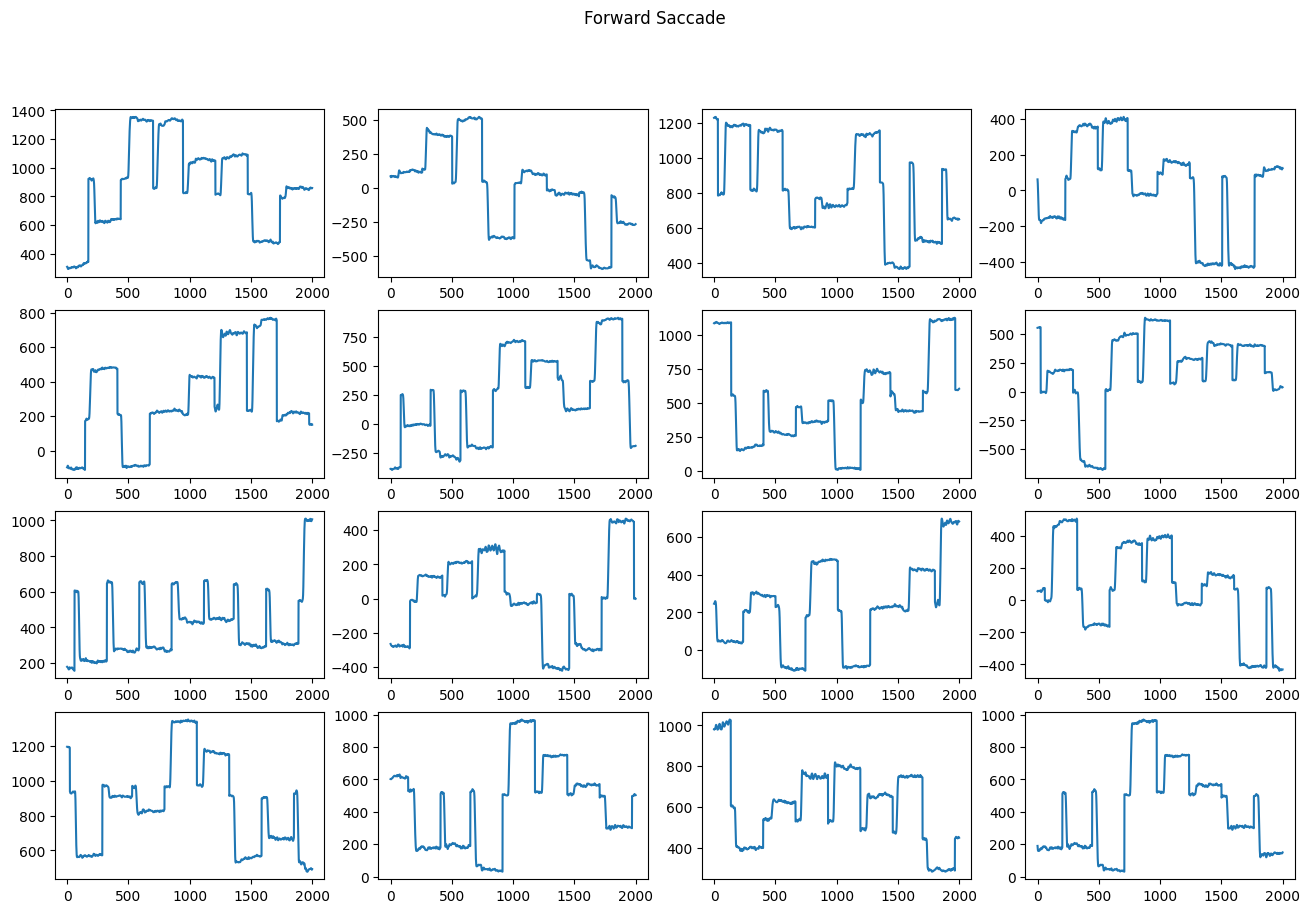

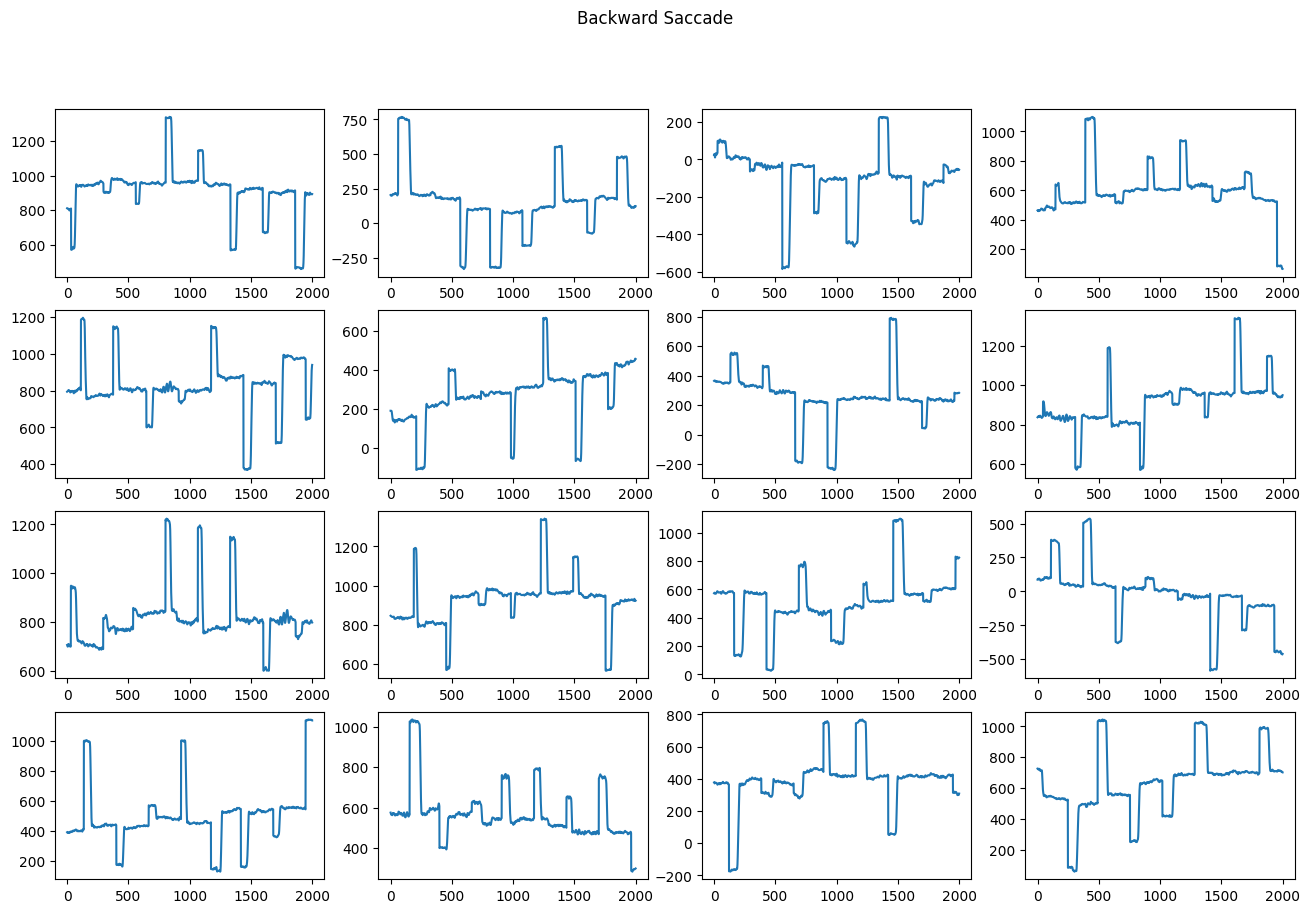

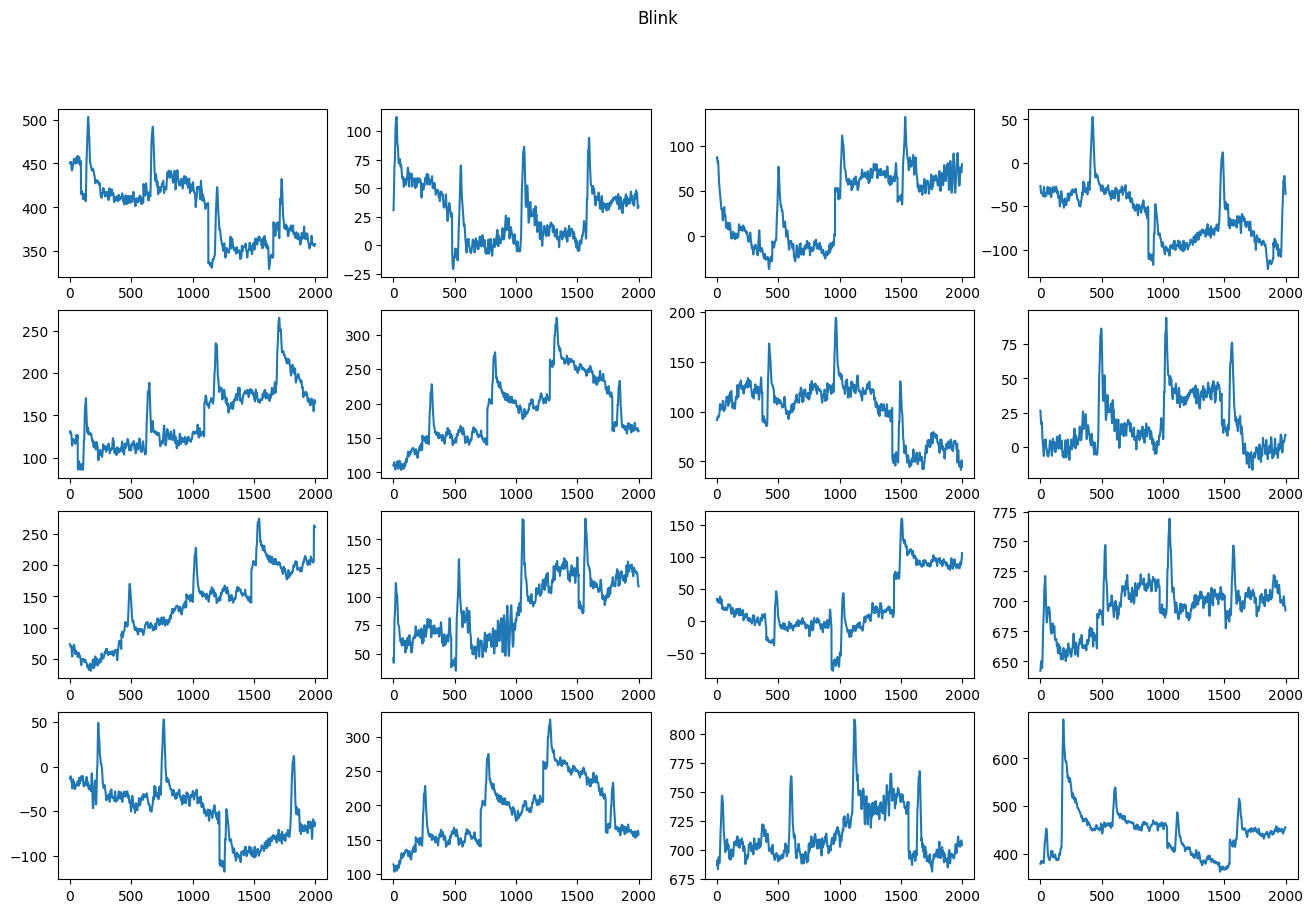

In [ ]:
# Horizontal component of EOG data
plt.figure(figsize=(16, 10))
a = np.random.randint(0, forward_saccade.shape[1]-2000, (16,))
plt.suptitle('Forward Saccade')
for i in range(16):
  plt.subplot(4, 4, i+1)
  plt.plot(forward_saccade[0, a[i]:a[i]+2000])

plt.figure(figsize=(16, 10))
a = np.random.randint(0, forward_saccade.shape[1]-2000, (16,))
plt.suptitle('Backward Saccade')
for i in range(16):
  plt.subplot(4, 4, i+1)
  plt.plot(backward_saccade[0, a[i]:a[i]+2000])

plt.figure(figsize=(16, 10))
a = np.random.randint(0, forward_saccade.shape[1]-2000, (16,))
plt.suptitle('Blink')
for i in range(16):
  plt.subplot(4, 4, i+1)
  plt.plot(blink[0, a[i]:a[i]+2000])

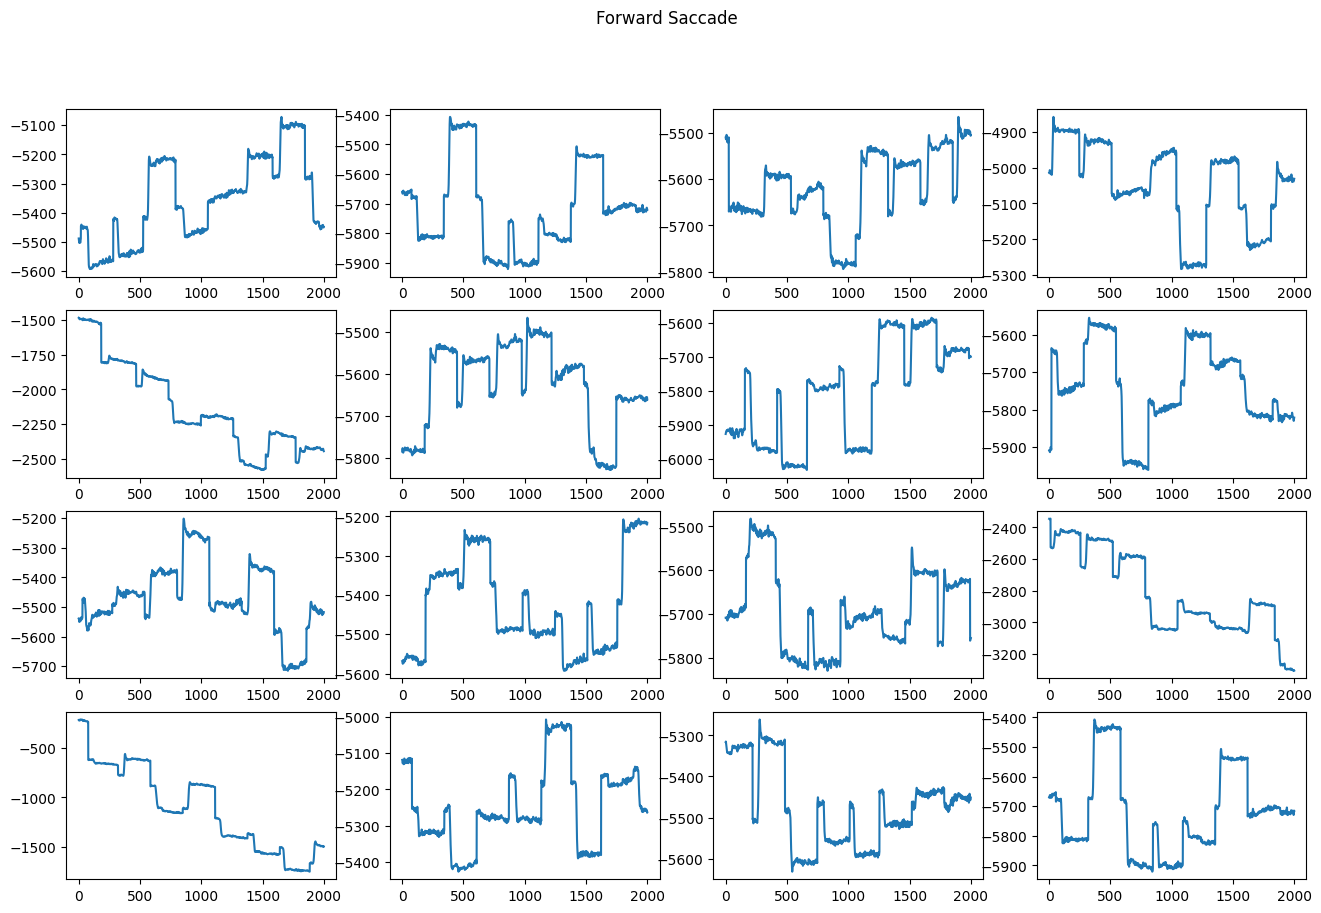

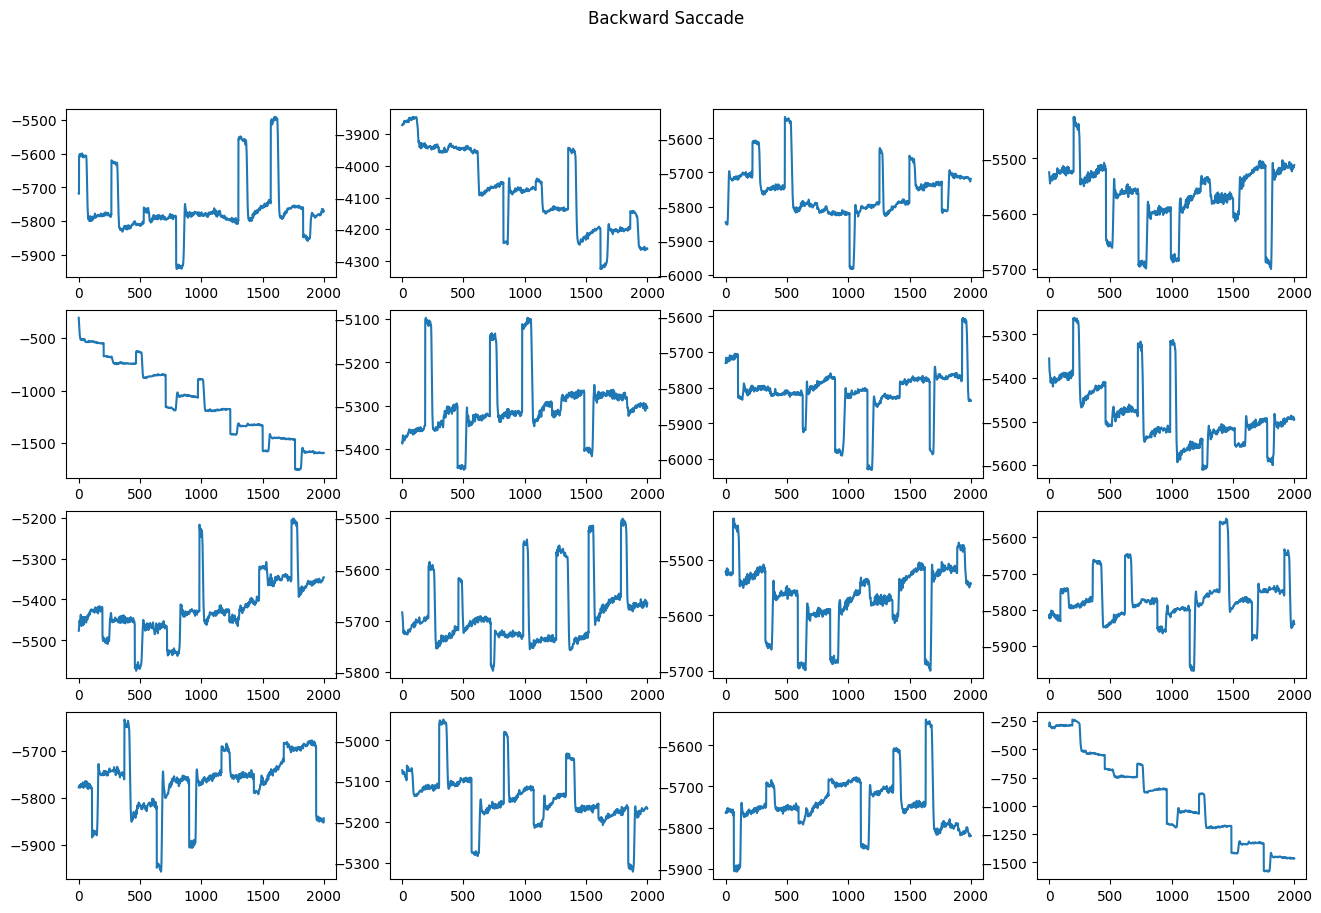

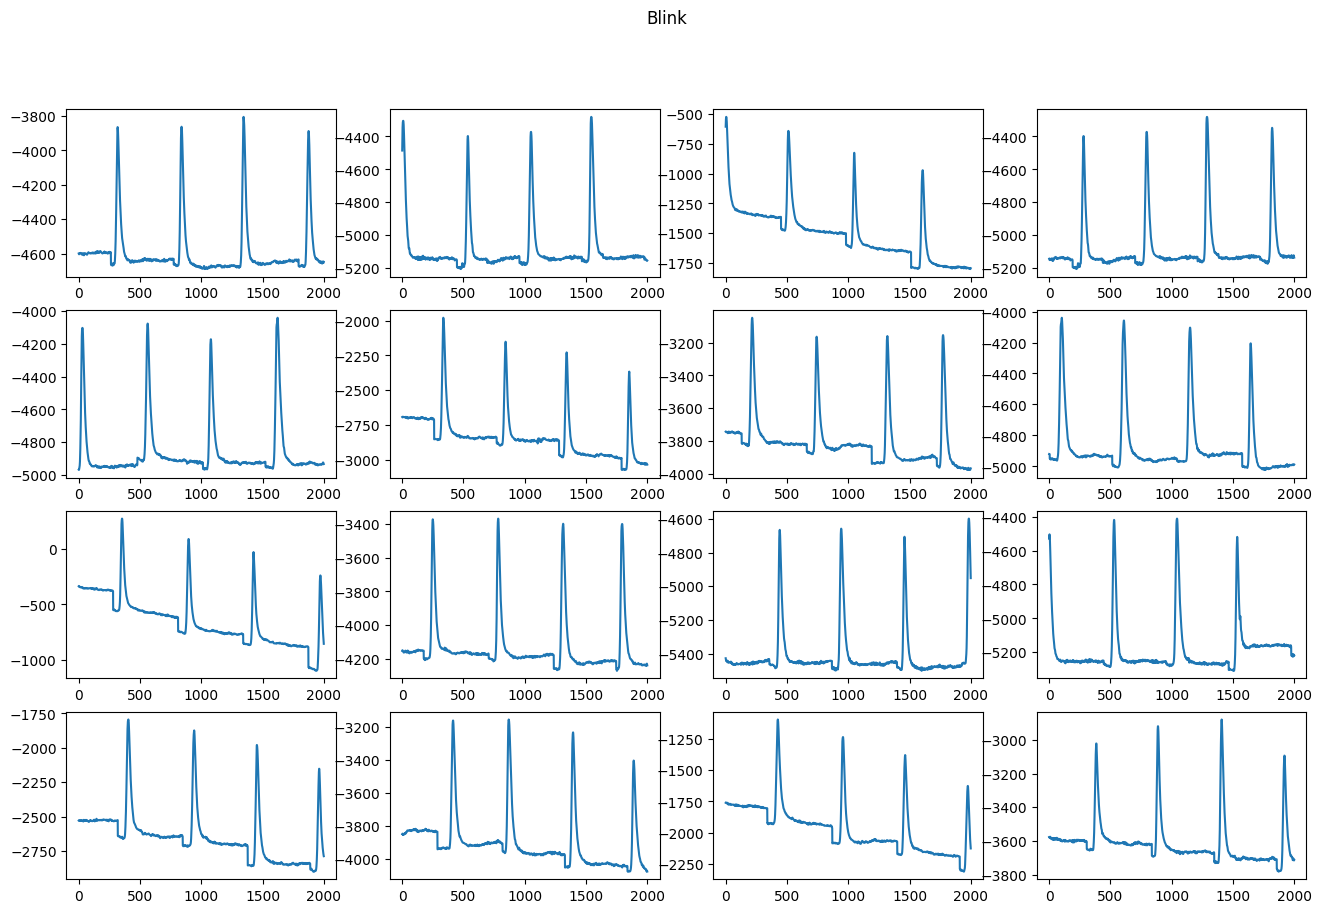

In [ ]:
# Vertical Component of EOG data
plt.figure(figsize=(16, 10))
a = np.random.randint(0, forward_saccade.shape[1]-2000, (16,))
plt.suptitle('Forward Saccade')
for i in range(16):
  plt.subplot(4, 4, i+1)
  plt.plot(forward_saccade[1, a[i]:a[i]+2000])

plt.figure(figsize=(16, 10))
a = np.random.randint(0, forward_saccade.shape[1]-2000, (16,))
plt.suptitle('Backward Saccade')
for i in range(16):
  plt.subplot(4, 4, i+1)
  plt.plot(backward_saccade[1, a[i]:a[i]+2000])

plt.figure(figsize=(16, 10))
a = np.random.randint(0, forward_saccade.shape[1]-2000, (16,))
plt.suptitle('Blink')
for i in range(16):
  plt.subplot(4, 4, i+1)
  plt.plot(blink[1, a[i]:a[i]+2000])

###**Notes on Time Domain**

Very clear differences between forward saccade, backward saccade, and blink. Forward saccades have steps that are the longest in duration, backward saccades have moderately sized steps, and blinks are a sharp peak as opposed to flat steps. Frequency domain analysis may also yield interesting results

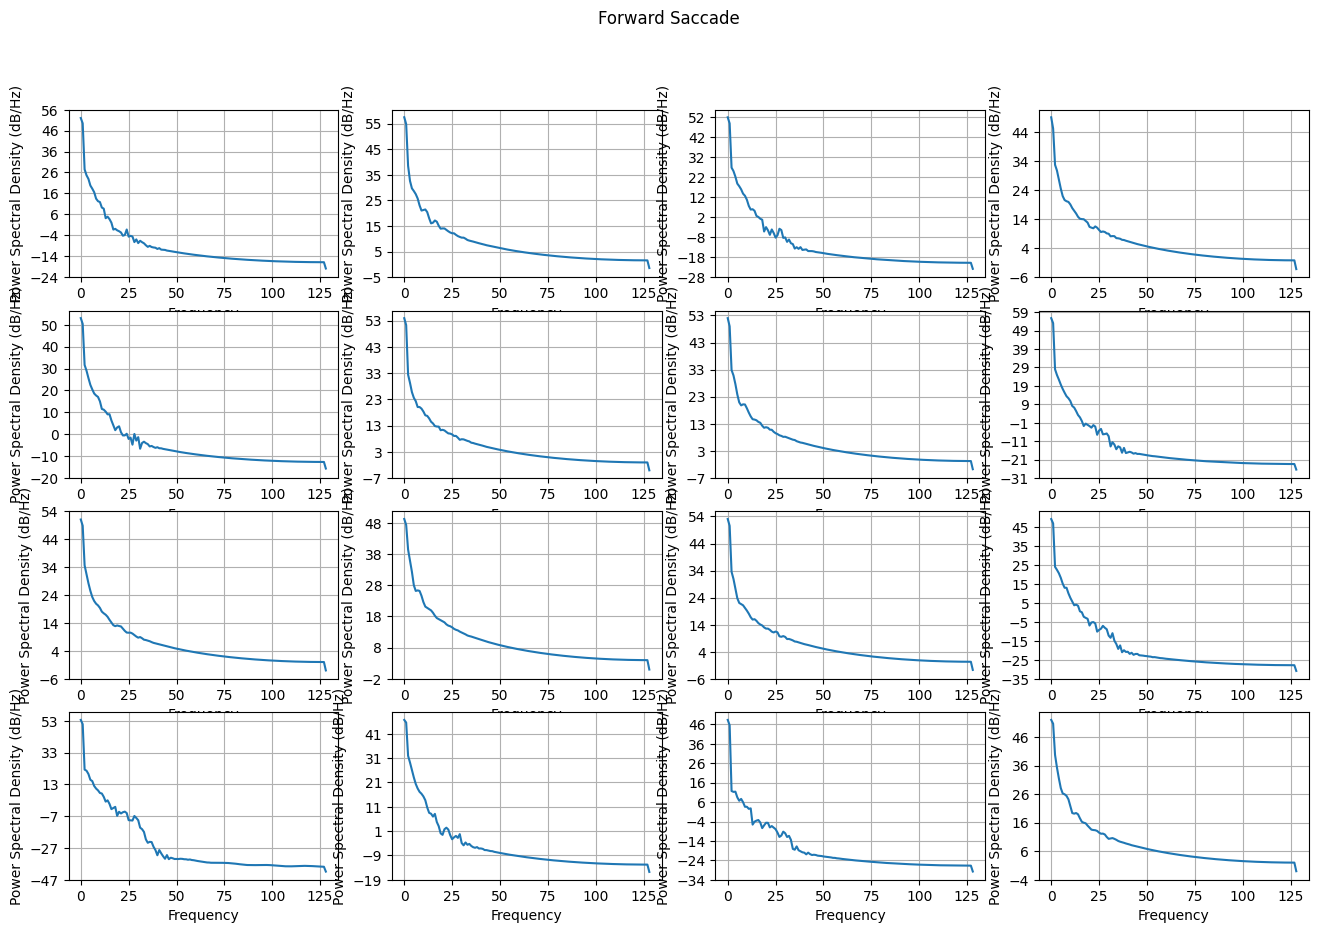

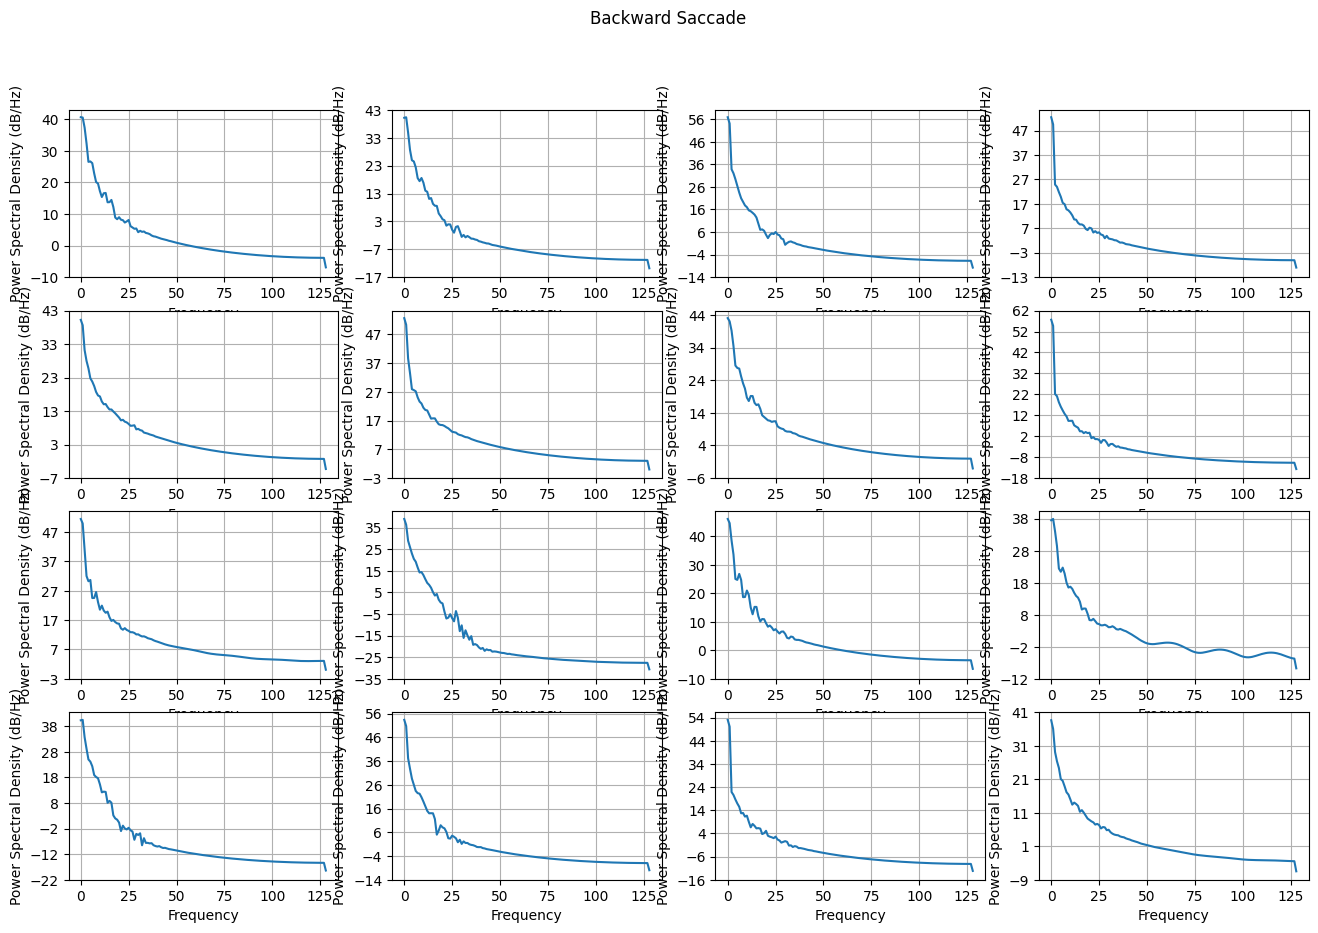

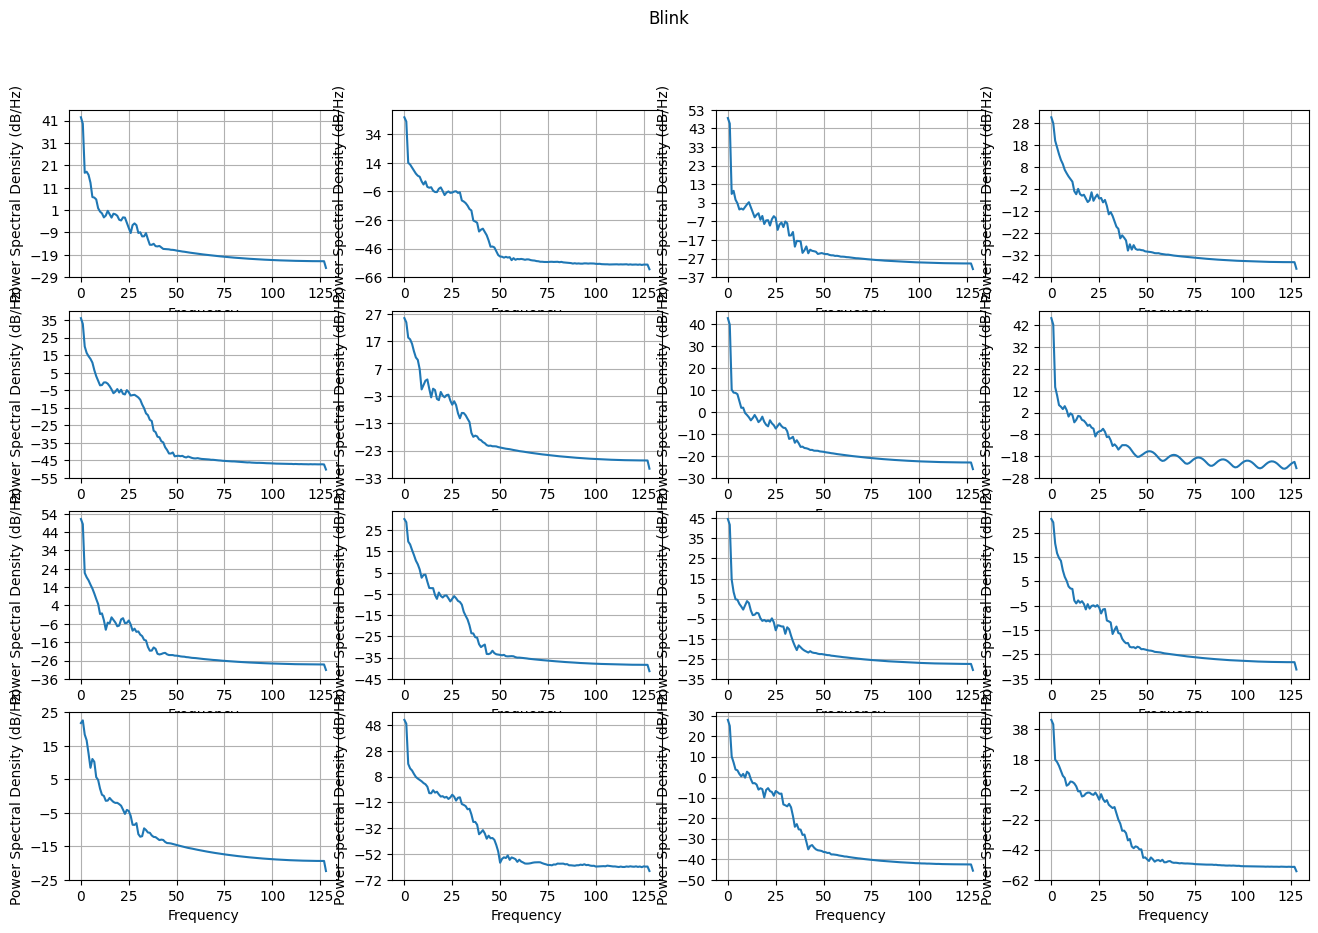

In [ ]:
# Horizontal component of EOG data in frequency domain at different time slices
# Effectively giving us time frequency information
plt.figure(figsize=(16, 10))
a = np.random.randint(0, forward_saccade.shape[1]-2000, (16,))
plt.suptitle('Forward Saccade')
for i in range(16):
  plt.subplot(4, 4, i+1)
  plt.psd(forward_saccade[0, a[i]:a[i]+2000], Fs=256)

plt.figure(figsize=(16, 10))
a = np.random.randint(0, forward_saccade.shape[1]-2000, (16,))
plt.suptitle('Backward Saccade')
for i in range(16):
  plt.subplot(4, 4, i+1)
  plt.psd(backward_saccade[0, a[i]:a[i]+2000], Fs=256)

plt.figure(figsize=(16, 10))
a = np.random.randint(0, forward_saccade.shape[1]-2000, (16,))
plt.suptitle('Blink')
for i in range(16):
  plt.subplot(4, 4, i+1)
  plt.psd(blink[0, a[i]:a[i]+2000], Fs=256)

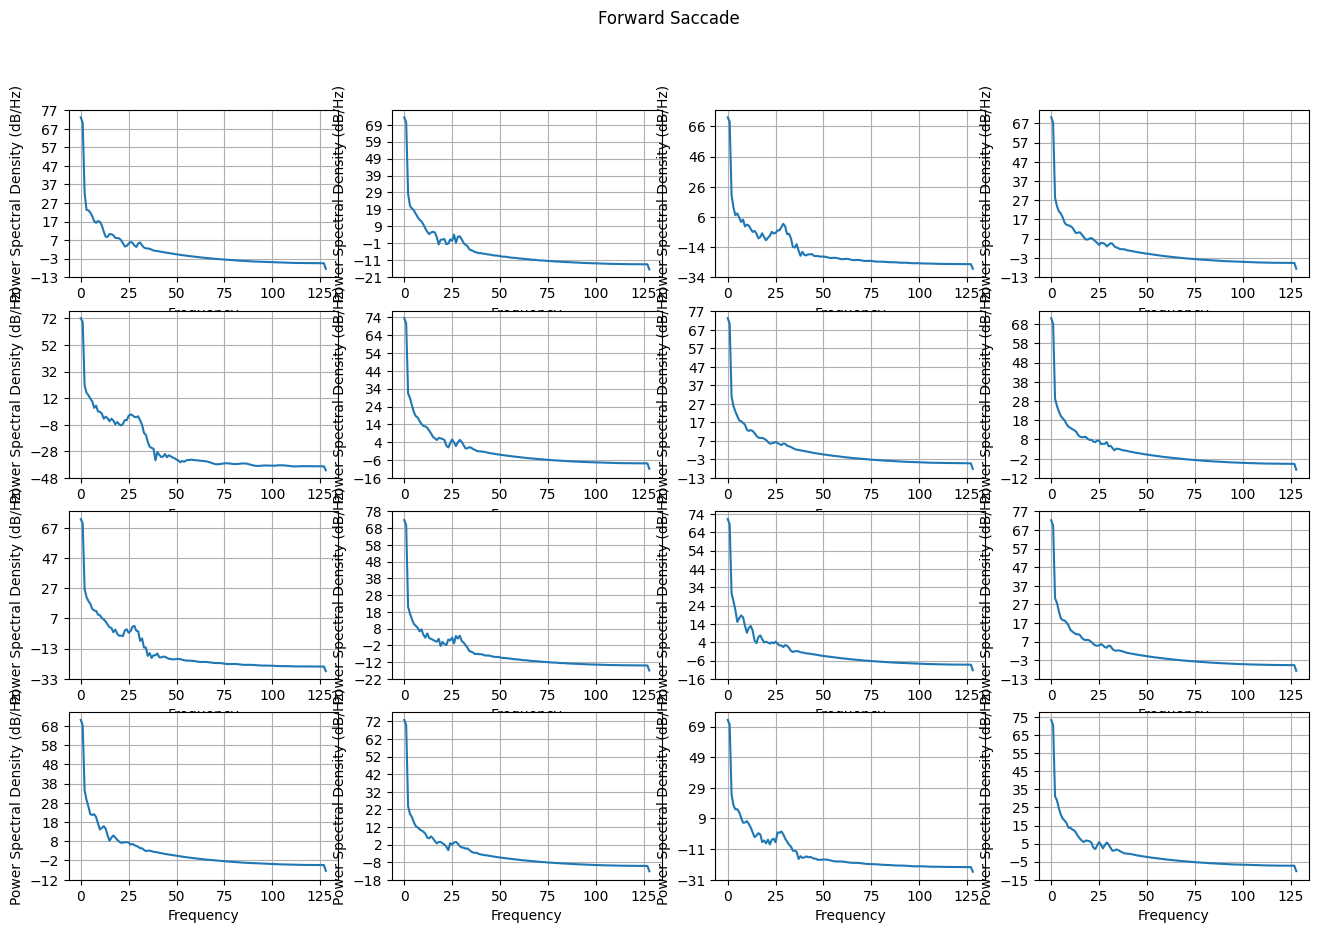

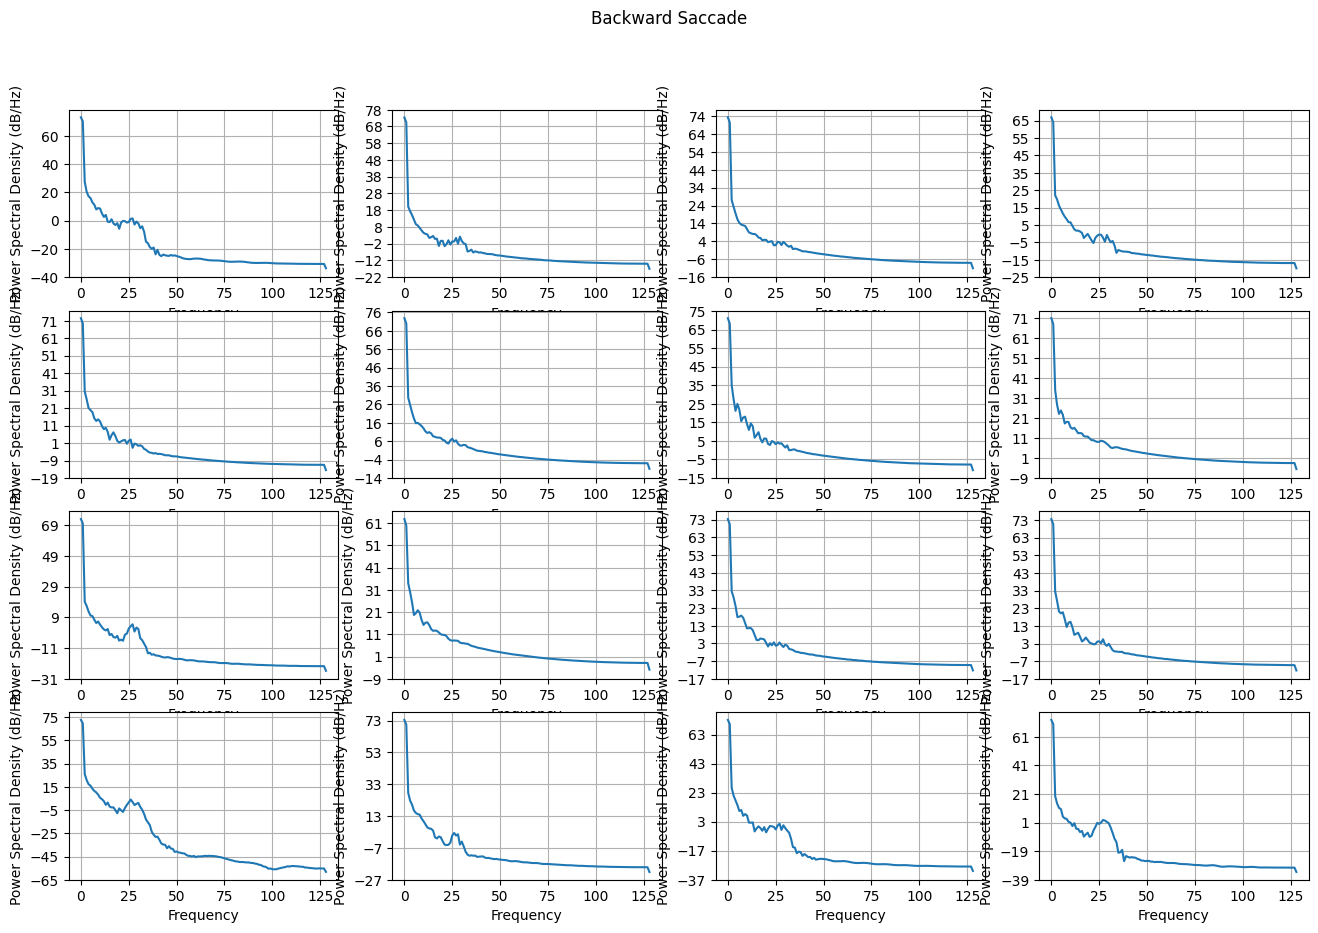

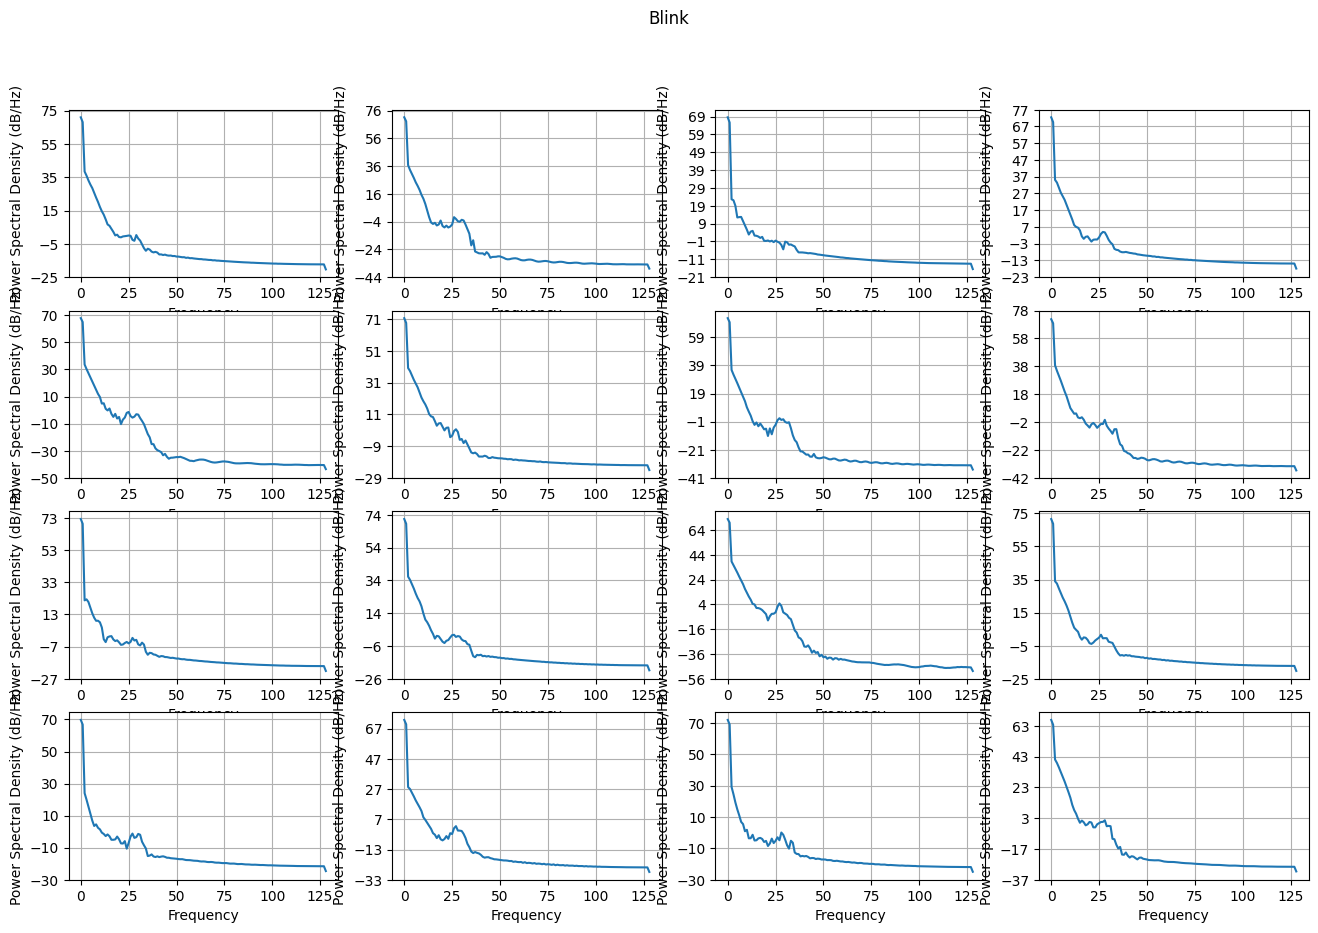

In [ ]:
# Vertical component of EOG data in frequency domain at different time slices
# Effectively giving us time frequency information
plt.figure(figsize=(16, 10))
a = np.random.randint(0, forward_saccade.shape[1]-2000, (16,))
plt.suptitle('Forward Saccade')
for i in range(16):
  plt.subplot(4, 4, i+1)
  plt.psd(forward_saccade[1, a[i]:a[i]+2000], Fs=256)

plt.figure(figsize=(16, 10))
a = np.random.randint(0, forward_saccade.shape[1]-2000, (16,))
plt.suptitle('Backward Saccade')
for i in range(16):
  plt.subplot(4, 4, i+1)
  plt.psd(backward_saccade[1, a[i]:a[i]+2000], Fs=256)

plt.figure(figsize=(16, 10))
a = np.random.randint(0, forward_saccade.shape[1]-2000, (16,))
plt.suptitle('Blink')
for i in range(16):
  plt.subplot(4, 4, i+1)
  plt.psd(blink[1, a[i]:a[i]+2000], Fs=256)

###Notes on Frequency Domain
Blinks have much more power in 5-15Hz band than saccades. Vertical component also has spikes in all three classes around 15Hz.

# Preprocessing


## Rebalancing

In [ ]:
# randomly selecting 50% of blink data to discard to balance classes
ind = np.random.randint(0, blink.shape[1]//2)
blink2 = blink[:, ind: ind+(blink.shape[1]//2)]

## Train-val-test split

In [ ]:
# Splitting the data into train, validation, and test sets
train_prop = 0.75
val_prop = 0.15

# Function to split data with random starting point for validation and test sets
# that cut out a contiguous slice. Test_prop is assumed to be 1 - (train_prop + val_prop).
def split_data_contiguous_random_start(data, train_prop, val_prop):
    num_samples = data.shape[1]
    num_train = int(num_samples * train_prop)
    num_val = int(num_samples * val_prop)
    num_test = num_samples - num_train - num_val

    # Randomly select a starting index for the combined contiguous block
    # ensure val start is in first half of signal
    val_start = np.random.randint(0, num_samples//2 - num_val)
    val_end = val_start + num_val

    # Define the end indices for each split within the contiguous block
    test_start = np.random.randint(val_end, num_samples - num_test)
    test_end = test_start + num_test

    # Extract contiguous segments for each split
    val_data = data[:, val_start:val_end]
    test_data = data[:, test_start:test_end]
    train_data = np.concatenate((data[:, :val_start], data[:, val_end:test_start], data[:, test_end:]), axis=1)

    return train_data, val_data, test_data

# Split each class with random starting point for contiguous segments
forward_saccade_train, forward_saccade_val, forward_saccade_test = split_data_contiguous_random_start(forward_saccade, train_prop, val_prop)
backward_saccade_train, backward_saccade_val, backward_saccade_test = split_data_contiguous_random_start(backward_saccade, train_prop, val_prop)
blink_train, blink_val, blink_test = split_data_contiguous_random_start(blink2, train_prop, val_prop)

print("Forward Saccade shapes:", forward_saccade_train.shape, forward_saccade_val.shape, forward_saccade_test.shape)
print("Backward Saccade shapes:", backward_saccade_train.shape, backward_saccade_val.shape, backward_saccade_test.shape)
print("Blink shapes:", blink_train.shape, blink_val.shape, blink_test.shape)

Forward Saccade shapes: (2, 58558) (2, 11711) (2, 7809)
Backward Saccade shapes: (2, 58399) (2, 11679) (2, 7788)
Blink shapes: (2, 58647) (2, 11729) (2, 7820)


## Window cropping

We are going to use window sliding to create signal chunks of the same shape and duration (4s), and use shifts smaller than the window size to get more samples and samples from different time frames

In [ ]:
def segmentation(signal, sampling_freq=125, window_size=1, window_shift=0.016):
  w_size = int(sampling_freq * window_size)
  w_shift = int(sampling_freq * window_shift)
  segments = []
  i = 0
  while i + w_size <= signal.shape[1]:
    segments.append(signal[:, i: i + w_size])
    i += w_shift
  return segments

In [ ]:
Fs = 256 # sampling frequency from data description pdf
forward_train_segments = segmentation(forward_saccade_train, Fs, window_size=4, window_shift=0.25)
forward_val_segments = segmentation(forward_saccade_val, Fs, window_size=4, window_shift=0.25)
forward_test_segments = segmentation(forward_saccade_test, Fs, window_size=4, window_shift=0.25)

backward_train_segments = segmentation(backward_saccade_train, Fs, window_size=4, window_shift=0.25)
backward_val_segments = segmentation(backward_saccade_val, Fs, window_size=4, window_shift=0.25)
backward_test_segments = segmentation(backward_saccade_test, Fs, window_size=4, window_shift=0.25)

blink_train_segments = segmentation(blink_train, Fs, window_size=4, window_shift=0.25)
blink_val_segments = segmentation(blink_val, Fs, window_size=4, window_shift=0.25)
blink_test_segments = segmentation(blink_test, Fs, window_size=4, window_shift=0.25)

In [ ]:
len(forward_train_segments), len(forward_val_segments), len(forward_test_segments)

(899, 167, 107)

In [ ]:
len(backward_train_segments), len(backward_val_segments), len(backward_test_segments)

(897, 167, 106)

In [ ]:
len(blink_train_segments), len(blink_val_segments), len(blink_test_segments)

(901, 168, 107)

## Making Dataloaders

class to idx:  
  forward: 0  
  backward: 1  
  blink: 2


In [ ]:
train_segments = forward_train_segments + backward_train_segments + blink_train_segments
val_segments = forward_val_segments + backward_val_segments + blink_val_segments
test_segments = forward_test_segments + backward_test_segments + blink_test_segments

train_labels = [0] * len(forward_train_segments) + [1] * len(backward_train_segments) + [2] * len(blink_train_segments)
val_labels = [0] * len(forward_val_segments) + [1] * len(backward_val_segments) + [2] * len(blink_val_segments)
test_labels = [0] * len(forward_test_segments) + [1] * len(backward_test_segments) + [2] * len(blink_test_segments)

train_tensor = torch.tensor(train_segments)
val_tensor = torch.tensor(val_segments)
test_tensor = torch.tensor(test_segments)
train_labels = torch.tensor(train_labels)
val_labels = torch.tensor(val_labels)
test_labels = torch.tensor(test_labels)

In [ ]:
print(train_tensor.shape, val_tensor.shape, test_tensor.shape)
print(train_labels.shape, val_labels.shape, test_labels.shape)

torch.Size([2697, 2, 1024]) torch.Size([502, 2, 1024]) torch.Size([320, 2, 1024])
torch.Size([2697]) torch.Size([502]) torch.Size([320])


In [ ]:
train_ds = TData(train_tensor, train_labels)
val_ds = TData(val_tensor, val_labels)
test_ds = TData(test_tensor, test_labels)

train_dl = DL(train_ds, batch_size=32, pin_memory=True, shuffle=True)
val_dl = DL(val_ds, batch_size=32, shuffle=True)
test_dl = DL(test_ds, batch_size=32, shuffle=True)

Testing data loader and visualizing a sample from a batch

In [ ]:
sig, lab = next(iter(val_dl))

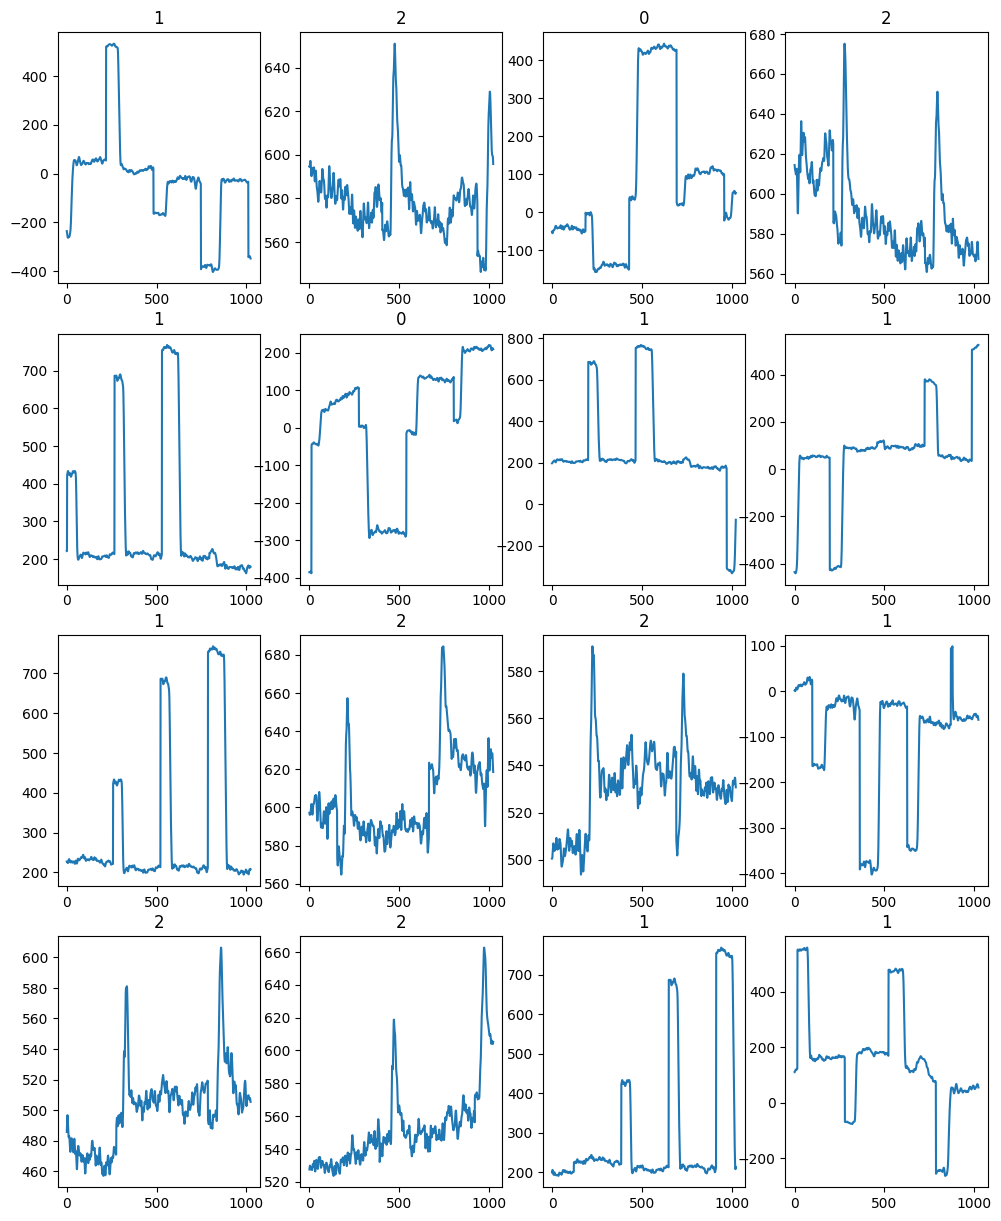

In [ ]:
plt.figure(figsize = (12, 15))
for i in range(16):
  plt.subplot(4, 4, i+1)
  plt.plot(sig[i, 0, :])
  plt.title(lab[i].item())
plt.show()

# Preliminary Model

In [ ]:
class EOGCNN(torch.nn.Module):
  def __init__(self, in_channels=2, out_classes=3):
    super(EOGCNN, self).__init__()
    self.conv1 = torch.nn.Conv1d(2, 16, kernel_size=3)
    self.conv2 = torch.nn.Conv1d(16, 32, kernel_size=3, dilation=1)
    self.relu = torch.nn.ReLU()
    self.pool = torch.nn.MaxPool1d(2, 2)
    self.conv3 = torch.nn.Conv1d(32, 64, kernel_size=3, dilation=2)
    self.conv4 = torch.nn.Conv1d(64, 128, kernel_size=5, dilation=3)
    self.flatten = torch.nn.Flatten()

    dummy_input = torch.randn(1, 2, 256 * 4)
    dummy_out = self.relu(self.conv2(self.conv1(dummy_input)))
    dummy_out = self.pool(dummy_out)
    dummy_out = self.relu(self.conv3(dummy_out))
    dummy_out = self.pool(dummy_out)
    dummy_out = self.flatten(dummy_out)
    self.fc = torch.nn.Linear(dummy_out.shape[1], 128)
    self.fc2 = torch.nn.Linear(128, out_classes)

  def forward(self, x):
    y = self.conv1(x)
    y = self.conv2(y)
    y = self.relu(y)
    y = self.pool(y)
    y = self.conv3(y)
    y = self.relu(y)
    y = self.pool(y)
    y = self.flatten(y)
    y = self.fc(y)
    y = self.fc2(y)
    return y

model = EOGCNN().to(device)

In [ ]:
from torchsummary import summary
summary(model, (2, 256 * 4))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1             [-1, 16, 1022]             112
            Conv1d-2             [-1, 32, 1020]           1,568
              ReLU-3             [-1, 32, 1020]               0
         MaxPool1d-4              [-1, 32, 510]               0
            Conv1d-5              [-1, 64, 506]           6,208
              ReLU-6              [-1, 64, 506]               0
         MaxPool1d-7              [-1, 64, 253]               0
           Flatten-8                [-1, 16192]               0
            Linear-9                  [-1, 128]       2,072,704
           Linear-10                    [-1, 3]             387
Total params: 2,080,979
Trainable params: 2,080,979
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 1.49
Params size (MB): 7.94
Estimat

## Training and Validation

In [ ]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
epochs = 15
train_losses = []
val_losses = []
val_accs = []
max_acc = 0.0

for epoch in range(epochs):
  model.train()
  pb = tqdm(total=len(train_dl))
  total_train_loss = 0.0
  for j, (signals, labels) in enumerate(train_dl):
    signals = signals.to(device).to(torch.float32)
    labels = labels.to(device)
    optimizer.zero_grad()
    outputs = model(signals)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
    total_train_loss += loss.item()
    pb.set_description(f"Epoch {epoch + 1}    loss={total_train_loss / (j + 1):.4f}")
    pb.update(1)
  pb.close()
  train_losses.append(total_train_loss / len(train_dl))
  with torch.no_grad():
    model.eval()
    pb = tqdm(total=len(val_dl))
    total_val_loss = 0.0
    total_val_acc = 0.0
    for j, (signals, labels) in enumerate(val_dl):
      signals = signals.to(device).to(torch.float32)
      labels = labels.to(device)
      outputs = model(signals)
      loss = criterion(outputs, labels)
      total_val_loss += loss.item()
      total_val_acc += (outputs.argmax(dim=1) == labels).float().mean().item()
      pb.set_description(f"val_loss={total_val_loss / (j + 1):.4f}    val_acc={total_val_acc / (j+1):.4f}")
      pb.update(1)
    pb.close()
    val_losses.append(total_val_loss / len(val_dl))
    val_acc = total_val_acc / len(val_dl)
    val_accs.append(val_acc)
    if val_acc > max_acc:
      max_acc = val_acc
      torch.save(model.state_dict(), 'best_eogcnn.pt')
      print('model saved')

  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

model saved


  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

model saved


  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

model saved


  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

In [ ]:
pb = tqdm(total=len(test_dl))
model.load_state_dict(torch.load('best_eogcnn.pt'))
model.eval()
total_test_loss = 0.0
total_test_acc = 0.0
for j, (signals, labels) in enumerate(test_dl):
  signals = signals.to(device).to(torch.float32)
  labels = labels.to(device)
  outputs = model(signals)
  loss = criterion(outputs, labels)
  total_test_loss += loss.item()
  total_test_acc += (outputs.argmax(dim=1) == labels).float().mean().item()
  pb.set_description(f"loss={total_test_loss / (j + 1):0.4f}")
  pb.update(1)
pb.close()
test_acc = total_test_acc / len(test_dl)
print(f"Test Accuracy: {test_acc}")
# results over last batch
print(classification_report(labels.cpu().numpy(), outputs.argmax(dim=1).cpu().numpy(), target_names=['forward', 'backward', 'blink']))

  0%|          | 0/10 [00:00<?, ?it/s]

Test Accuracy: 0.60625
              precision    recall  f1-score   support

     forward       0.00      0.00      0.00        11
    backward       0.83      0.62      0.71         8
       blink       0.50      1.00      0.67        13

    accuracy                           0.56        32
   macro avg       0.44      0.54      0.46        32
weighted avg       0.41      0.56      0.45        32



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## Performance Plots

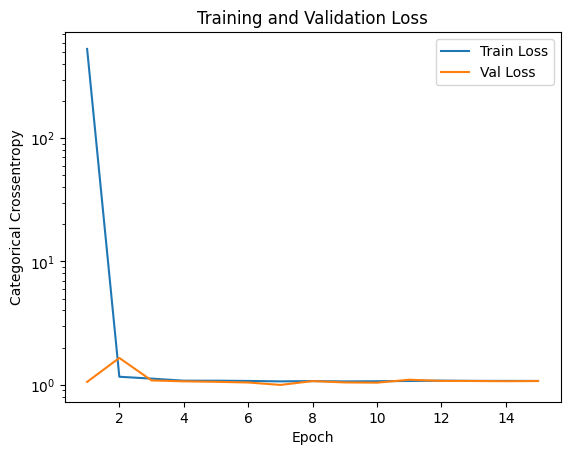

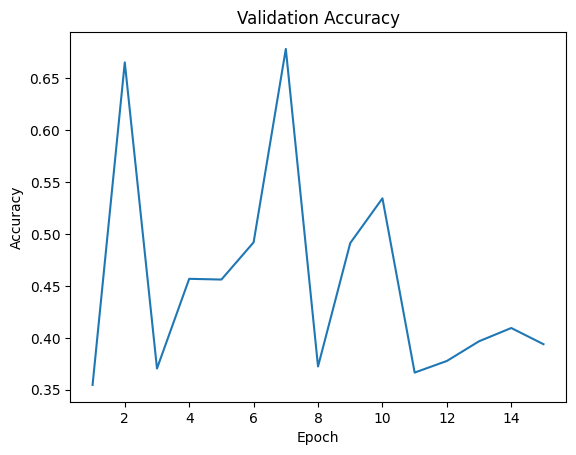

In [ ]:
plt.figure()
plt.semilogy(range(1, len(train_losses)+1), train_losses, label='Train Loss')
plt.semilogy(range(1, len(val_losses)+1), val_losses, label='Val Loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Categorical Crossentropy')
plt.title('Training and Validation Loss')
plt.show()

plt.figure()
plt.plot(range(1, len(val_accs)+1), val_accs)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')
plt.show()

# Optuna: Automatic Hyperparameter Optimization

Here are the optuna docs for reference: https://optuna.readthedocs.io/en/stable/reference/index.html

In [ ]:
import optuna

## Model definition and training with trial suggest

In [ ]:
def model_struct(trial):
  layers = []
  n_conv = trial.suggest_int('n_conv', 1, 4) # decide on number of conv layers
  last_in_channels = 2
  for i in range(n_conv):
    kernel_size = trial.suggest_int(f'kernel_size_{i}', 3, 7)
    filters = trial.suggest_categorical(f"num_filts_{i}", [2 ** i for i in range(3, 8)])
    dilation = trial.suggest_int(f'dilation_{i}', 1, 3)
    conv = torch.nn.Conv1d(last_in_channels, filters, kernel_size=kernel_size, dilation=dilation)
    last_in_channels = filters
    layers.append(conv)
    layers.append(torch.nn.BatchNorm1d(filters))
    layers.append(torch.nn.ReLU())
    pool_kernel = trial.suggest_int(f'pool_kernel_{i}', 2, 4)
    pool_stride = trial.suggest_int(f'pool_stride_{i}', 1, 3)
    layers.append(torch.nn.MaxPool1d(pool_kernel, pool_stride))


  layers.append(torch.nn.Flatten())
  dummy_input = torch.randn(1, 2, 256 * 4)
  dummy_out = dummy_input
  for layer in layers: # calculating output shape after passing through previous layers
    dummy_out = layer(dummy_out)
  last_in_channels = dummy_out.shape[1]

  n_linear = trial.suggest_int('n_linear', 0, 2) # 0-2 intermediate linear layers before final layer
  for j in range(n_linear):
    out_channels = trial.suggest_categorical(f"out_channels_{j}", [2 ** i for i in range(3, 8)])
    dropout = trial.suggest_float(f"dropout_{j}", 0.0, 0.5)
    layers.append(torch.nn.Linear(last_in_channels, out_channels))
    layers.append(torch.nn.Dropout(dropout))
    last_in_channels = out_channels
  layers.append(torch.nn.Linear(last_in_channels, 3)) # adding final classification layer

  model = torch.nn.Sequential(*layers)
  trial.set_user_attr('tuned_model', model) # saves model as attr so we can save best performing model
  return model

def train_and_validate(trial, model, optimizer):
  criterion = torch.nn.CrossEntropyLoss()
  epochs = 30
  train_losses = []
  val_losses = []
  val_accs = []
  max_acc = 0.0

  for epoch in range(epochs):
    model.train()
    pb = tqdm(total=len(train_dl))
    total_train_loss = 0.0
    for j, (signals, labels) in enumerate(train_dl):
      signals = signals.to(device).to(torch.float32)
      labels = labels.to(device)
      optimizer.zero_grad()
      outputs = model(signals)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()
      total_train_loss += loss.item()
      pb.set_description(f"Epoch {epoch + 1}    loss={total_train_loss / (j + 1):.4f}")
      pb.update(1)
    pb.close()
    train_losses.append(total_train_loss / len(train_dl))
    with torch.no_grad():
      model.eval()
      pb = tqdm(total=len(val_dl))
      total_val_loss = 0.0
      total_val_acc = 0.0
      for j, (signals, labels) in enumerate(val_dl):
        signals = signals.to(device).to(torch.float32)
        labels = labels.to(device)
        outputs = model(signals)
        loss = criterion(outputs, labels)
        total_val_loss += loss.item()
        total_val_acc += (outputs.argmax(dim=1) == labels).float().mean().item()
        pb.set_description(f"val_loss={total_val_loss / (j + 1):.4f}    val_acc={total_val_acc / (j+1):.4f}")
        pb.update(1)
      pb.close()
      val_losses.append(total_val_loss / len(val_dl))
      val_acc = total_val_acc / len(val_dl)
      val_accs.append(val_acc)
      if val_acc > max_acc:
        max_acc = val_acc
        trial.user_attrs['tuned_model'] = model
        print('model saved')

      # median pruning based on average val loss in an epoch
      trial.report(total_val_loss / len(val_dl), epoch)
      if trial.should_prune():
        raise optuna.TrialPruned()
  return val_losses

## Study design, objectives, and callbacks

In [ ]:
#callback saves best model as a study attribute
def callback(study, trial):
  if study.best_trial.number == trial.number:
    study.set_user_attr(key="tuned_eogcnn", value=trial.user_attrs["tuned_model"])

# minimize the average validation crossentropy loss over the last five epochs
def objective(trial):
  model = model_struct(trial)
  model.to(device)

  # trial suggests for optimizer and optimizer parameters
  lr = trial.suggest_float("lr", 5e-5, 1e-2)
  weight_decay = trial.suggest_float("weight_decay", 1e-4, 1e-2)
  optimizer = trial.suggest_categorical("optimizer", ["Adam", "SGD"])
  optimizer = getattr(torch.optim, optimizer)(model.parameters(), lr=lr, weight_decay=weight_decay)

  val_losses = train_and_validate(trial, model, optimizer)
  # saving optimizer parameters as well in case we want to train or tune further
  trial.set_user_attr('tuned_optimizer', optimizer)
  if len(val_losses) >= 5:
    return sum(val_losses[-5:]) / 5
  return val_losses[-1]

Sampler Options
- TPES (Kind of Bayesian optimization based on tree structure)
- Grid Search
- CMAES (Neuroevolution)
- GP (Bayesian Gridsearch)

Pruner Options to end unpromising trials
- MedianPruner prunes based on whether loss/metric at current step is less than median of loss/metric at same step in previous trials
- ThresholdPruner prunes based on manually set lower and upper bounds
- PatientPruner wrapper for other pruners that prunes based on a tolerance and patience level

In [ ]:
base_pruner = optuna.pruners.MedianPruner(n_startup_trials=4, n_warmup_steps=4)
patient_median = optuna.pruners.PatientPruner(base_pruner, patience=4)
# median pruner that provides some grace to potentially good trials with higher variance in
# validation loss between steps/iterations
study = optuna.create_study(pruner=patient_median) # default is TPES sampler
study.optimize(objective, n_trials=30, callbacks=[callback])

# load best model
tuned_eogmodel = study.user_attrs['tuned_eogcnn']

print(f"Number of finished trials: {len(study.trials)}")
print(f"Best trial:")
print("\tValue: ", study.best_trial.value)

print("\tParams: ")
for key, value in study.best_trial.params.items():
    print("    {}: {}".format(key, value))

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

model saved


  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

[I 2025-10-05 04:17:49,425] Trial 18 finished with value: 0.778370687190909 and parameters: {'n_conv': 4, 'kernel_size_0': 6, 'num_filts_0': 16, 'dilation_0': 3, 'pool_kernel_0': 4, 'pool_stride_0': 3, 'kernel_size_1': 4, 'num_filts_1': 8, 'dilation_1': 3, 'pool_kernel_1': 4, 'pool_stride_1': 3, 'kernel_size_2': 7, 'num_filts_2': 16, 'dilation_2': 3, 'pool_kernel_2': 3, 'pool_stride_2': 2, 'kernel_size_3': 4, 'num_filts_3': 16, 'dilation_3': 1, 'pool_kernel_3': 4, 'pool_stride_3': 1, 'n_linear': 1, 'out_channels_0': 128, 'dropout_0': 0.025702849682526813, 'lr': 0.007341210965993743, 'weight_decay': 0.009885891688856889, 'optimizer': 'Adam'}. Best is trial 16 with value: 0.3409813904203475.


  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

model saved


  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

model saved


  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

model saved


  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

model saved


  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

model saved


  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

model saved


  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

model saved


  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

[I 2025-10-05 04:18:11,396] Trial 19 finished with value: 0.5064372641034425 and parameters: {'n_conv': 3, 'kernel_size_0': 6, 'num_filts_0': 16, 'dilation_0': 1, 'pool_kernel_0': 4, 'pool_stride_0': 3, 'kernel_size_1': 3, 'num_filts_1': 8, 'dilation_1': 2, 'pool_kernel_1': 4, 'pool_stride_1': 3, 'kernel_size_2': 6, 'num_filts_2': 16, 'dilation_2': 3, 'pool_kernel_2': 2, 'pool_stride_2': 2, 'n_linear': 1, 'out_channels_0': 128, 'dropout_0': 0.085055582643412, 'lr': 0.005168212835396625, 'weight_decay': 0.0014967890491426336, 'optimizer': 'Adam'}. Best is trial 16 with value: 0.3409813904203475.


  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

model saved


  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

model saved


  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

model saved


  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

model saved


  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

model saved


  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

[I 2025-10-05 04:18:33,840] Trial 20 finished with value: 0.3373099836986512 and parameters: {'n_conv': 4, 'kernel_size_0': 5, 'num_filts_0': 16, 'dilation_0': 2, 'pool_kernel_0': 4, 'pool_stride_0': 3, 'kernel_size_1': 4, 'num_filts_1': 8, 'dilation_1': 3, 'pool_kernel_1': 4, 'pool_stride_1': 3, 'kernel_size_2': 6, 'num_filts_2': 8, 'dilation_2': 3, 'pool_kernel_2': 3, 'pool_stride_2': 2, 'kernel_size_3': 4, 'num_filts_3': 16, 'dilation_3': 1, 'pool_kernel_3': 4, 'pool_stride_3': 3, 'n_linear': 0, 'lr': 0.003966919016560792, 'weight_decay': 0.008444251456260437, 'optimizer': 'Adam'}. Best is trial 20 with value: 0.3373099836986512.


  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

model saved


  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

model saved


  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

model saved


  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

model saved


  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

model saved


  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

model saved


  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

[I 2025-10-05 04:18:57,122] Trial 21 finished with value: 0.7924994285218417 and parameters: {'n_conv': 4, 'kernel_size_0': 5, 'num_filts_0': 16, 'dilation_0': 2, 'pool_kernel_0': 4, 'pool_stride_0': 3, 'kernel_size_1': 4, 'num_filts_1': 8, 'dilation_1': 3, 'pool_kernel_1': 4, 'pool_stride_1': 3, 'kernel_size_2': 6, 'num_filts_2': 8, 'dilation_2': 3, 'pool_kernel_2': 3, 'pool_stride_2': 2, 'kernel_size_3': 4, 'num_filts_3': 16, 'dilation_3': 1, 'pool_kernel_3': 4, 'pool_stride_3': 3, 'n_linear': 0, 'lr': 0.004433197739878216, 'weight_decay': 0.008838408192420695, 'optimizer': 'Adam'}. Best is trial 20 with value: 0.3373099836986512.


  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

model saved


  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

model saved


  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

model saved


  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

model saved


  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

[I 2025-10-05 04:19:19,610] Trial 22 finished with value: 0.5646183115430177 and parameters: {'n_conv': 4, 'kernel_size_0': 5, 'num_filts_0': 16, 'dilation_0': 3, 'pool_kernel_0': 4, 'pool_stride_0': 3, 'kernel_size_1': 4, 'num_filts_1': 8, 'dilation_1': 3, 'pool_kernel_1': 4, 'pool_stride_1': 3, 'kernel_size_2': 6, 'num_filts_2': 8, 'dilation_2': 3, 'pool_kernel_2': 3, 'pool_stride_2': 2, 'kernel_size_3': 4, 'num_filts_3': 16, 'dilation_3': 1, 'pool_kernel_3': 4, 'pool_stride_3': 3, 'n_linear': 0, 'lr': 0.0038135945655335185, 'weight_decay': 0.008011665328741873, 'optimizer': 'Adam'}. Best is trial 20 with value: 0.3373099836986512.


model saved


  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

model saved


  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

model saved


  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

model saved


  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

model saved


  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

[I 2025-10-05 04:19:43,890] Trial 23 finished with value: 0.22385723530314863 and parameters: {'n_conv': 4, 'kernel_size_0': 5, 'num_filts_0': 16, 'dilation_0': 1, 'pool_kernel_0': 4, 'pool_stride_0': 3, 'kernel_size_1': 3, 'num_filts_1': 8, 'dilation_1': 3, 'pool_kernel_1': 4, 'pool_stride_1': 3, 'kernel_size_2': 7, 'num_filts_2': 64, 'dilation_2': 3, 'pool_kernel_2': 3, 'pool_stride_2': 3, 'kernel_size_3': 3, 'num_filts_3': 16, 'dilation_3': 3, 'pool_kernel_3': 2, 'pool_stride_3': 3, 'n_linear': 1, 'out_channels_0': 128, 'dropout_0': 0.06663638229384956, 'lr': 0.0016921326778621885, 'weight_decay': 0.006508089655212248, 'optimizer': 'Adam'}. Best is trial 23 with value: 0.22385723530314863.


  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

model saved


  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

model saved


  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

model saved


  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

model saved


  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

model saved


  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

model saved


  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

[I 2025-10-05 04:20:05,891] Trial 24 pruned. 


  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

model saved


  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

model saved


  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

model saved


  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

model saved


  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

model saved


  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

model saved


  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

model saved


  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

model saved


  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

model saved


  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

[I 2025-10-05 04:20:28,735] Trial 25 finished with value: 0.27941041747108103 and parameters: {'n_conv': 4, 'kernel_size_0': 5, 'num_filts_0': 16, 'dilation_0': 2, 'pool_kernel_0': 4, 'pool_stride_0': 3, 'kernel_size_1': 3, 'num_filts_1': 32, 'dilation_1': 3, 'pool_kernel_1': 4, 'pool_stride_1': 3, 'kernel_size_2': 7, 'num_filts_2': 64, 'dilation_2': 3, 'pool_kernel_2': 3, 'pool_stride_2': 3, 'kernel_size_3': 4, 'num_filts_3': 128, 'dilation_3': 3, 'pool_kernel_3': 2, 'pool_stride_3': 3, 'n_linear': 0, 'lr': 0.0015456622411343856, 'weight_decay': 0.00891225148851665, 'optimizer': 'Adam'}. Best is trial 23 with value: 0.22385723530314863.


  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

model saved


  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

model saved


  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

model saved


  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

model saved


  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

[I 2025-10-05 04:20:35,066] Trial 26 pruned. 


  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

model saved


  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

model saved


  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

model saved


  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

model saved


  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

model saved


  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

model saved


  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

model saved


  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

model saved


  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

model saved


  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

model saved


  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

[I 2025-10-05 04:20:57,407] Trial 27 finished with value: 0.4523785227909684 and parameters: {'n_conv': 4, 'kernel_size_0': 4, 'num_filts_0': 16, 'dilation_0': 3, 'pool_kernel_0': 4, 'pool_stride_0': 3, 'kernel_size_1': 3, 'num_filts_1': 32, 'dilation_1': 2, 'pool_kernel_1': 3, 'pool_stride_1': 3, 'kernel_size_2': 6, 'num_filts_2': 64, 'dilation_2': 2, 'pool_kernel_2': 3, 'pool_stride_2': 3, 'kernel_size_3': 5, 'num_filts_3': 128, 'dilation_3': 3, 'pool_kernel_3': 2, 'pool_stride_3': 2, 'n_linear': 0, 'lr': 0.00014984594740480696, 'weight_decay': 0.008875294382448622, 'optimizer': 'Adam'}. Best is trial 23 with value: 0.22385723530314863.


  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

model saved


  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

model saved


  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

model saved


  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

[I 2025-10-05 04:21:03,999] Trial 28 pruned. 


  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

model saved


  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

model saved


  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

model saved


  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

model saved


  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

model saved


  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

model saved


  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

model saved


  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

model saved


  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

[I 2025-10-05 04:21:25,163] Trial 29 finished with value: 0.7116049989126623 and parameters: {'n_conv': 3, 'kernel_size_0': 5, 'num_filts_0': 32, 'dilation_0': 2, 'pool_kernel_0': 4, 'pool_stride_0': 3, 'kernel_size_1': 3, 'num_filts_1': 128, 'dilation_1': 3, 'pool_kernel_1': 3, 'pool_stride_1': 3, 'kernel_size_2': 7, 'num_filts_2': 64, 'dilation_2': 3, 'pool_kernel_2': 3, 'pool_stride_2': 3, 'n_linear': 0, 'lr': 0.001039808745736272, 'weight_decay': 0.007427838079476919, 'optimizer': 'Adam'}. Best is trial 23 with value: 0.22385723530314863.


Number of finished trials: 30
Best trial:
	Value:  0.22385723530314863
	Params: 
    n_conv: 4
    kernel_size_0: 5
    num_filts_0: 16
    dilation_0: 1
    pool_kernel_0: 4
    pool_stride_0: 3
    kernel_size_1: 3
    num_filts_1: 8
    dilation_1: 3
    pool_kernel_1: 4
    pool_stride_1: 3
    kernel_size_2: 7
    num_filts_2: 64
    dilation_2: 3
    pool_kernel_2: 3
    pool_stride_2: 3
    kernel_size_3: 3
    num_filts_3: 16
    dilation_3: 3
    pool_kernel_3: 2
    pool_stride_3: 3
    n_linear: 1
    out_channels_0: 128
    dropout_0: 0.06663638229384956
    lr: 0.0016921326778621885
    weight_decay: 0.006508089655212248
    optimizer: Adam


## Final Tuned EOG CNN performance

In [ ]:
pb = tqdm(total=len(test_dl))
tuned_eogmodel.eval()
total_test_loss = 0.0
total_test_acc = 0.0
for j, (signals, labels) in enumerate(test_dl):
  signals = signals.to(device).to(torch.float32)
  labels = labels.to(device)
  outputs = tuned_eogmodel(signals)
  loss = criterion(outputs, labels)
  total_test_loss += loss.item()
  total_test_acc += (outputs.argmax(dim=1) == labels).float().mean().item()
  pb.set_description(f"loss={total_test_loss / (j + 1):0.4f}")
  pb.update(1)
pb.close()
test_acc = total_test_acc / len(test_dl)
print(f"Test Accuracy: {test_acc}")
# results over last batch
print(classification_report(labels.cpu().numpy(), outputs.argmax(dim=1).cpu().numpy(), target_names=['forward', 'backward', 'blink']))

  0%|          | 0/10 [00:00<?, ?it/s]

Test Accuracy: 0.9875
              precision    recall  f1-score   support

     forward       1.00      1.00      1.00        12
    backward       1.00      1.00      1.00         9
       blink       1.00      1.00      1.00        11

    accuracy                           1.00        32
   macro avg       1.00      1.00      1.00        32
weighted avg       1.00      1.00      1.00        32



### Model gets >98% accuracy on test set!

In [ ]:
torch.save(tuned_eogmodel, 'tuned_eogcnn.pth')

Loading the model and getting classification report over full test set

In [ ]:
best_model = torch.load("tuned_eogcnn.pth", weights_only=False)
best_model.eval()
test_dl = DL(test_ds, batch_size=len(test_ds), shuffle=True)
pb = tqdm(total=len(test_dl))
total_test_loss = 0.0
total_test_acc = 0.0
for j, (signals, labels) in enumerate(test_dl):
  signals = signals.to(device).to(torch.float32)
  labels = labels.to(device)
  outputs = best_model(signals)
  loss = criterion(outputs, labels)
  total_test_loss += loss.item()
  total_test_acc += (outputs.argmax(dim=1) == labels).float().mean().item()
  pb.set_description(f"loss={total_test_loss / (j + 1):0.4f}")
  pb.update(1)
pb.close()
test_acc = total_test_acc / len(test_dl)
print(f"Test Accuracy: {test_acc}")
# results over last batch
print(classification_report(labels.cpu().numpy(), outputs.argmax(dim=1).cpu().numpy(), target_names=['forward', 'backward', 'blink']))

  0%|          | 0/1 [00:00<?, ?it/s]

Test Accuracy: 0.987500011920929
              precision    recall  f1-score   support

     forward       1.00      0.96      0.98       107
    backward       0.98      1.00      0.99       106
       blink       0.98      1.00      0.99       107

    accuracy                           0.99       320
   macro avg       0.99      0.99      0.99       320
weighted avg       0.99      0.99      0.99       320

